In [1]:
### Denoising Adverarial Autoencoder (sprites) : Version 2 : matching q*(z|x) to p(z)
#if n_hidden==n uses nD normal prior

In [2]:
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, Deconv2DLayer, flatten, reshape, batch_norm
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import LeakyRectify as lrelu
from lasagne.nonlinearities import sigmoid
from lasagne.layers import get_output, get_all_params, get_output_shape
from lasagne.objectives import binary_crossentropy as bce
from lasagne.objectives import squared_error
from lasagne.updates import adam,sgd
from lasagne.regularization import l2, l1
from lasagne.regularization import regularize_layer_params

import numpy as np
import theano
from theano import tensor as T
import time
from matplotlib import pyplot as plt 
%matplotlib inline

from skimage.io import imsave
from skimage.color import rgb2gray

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn import neighbors

#for log likelihood
from ll import ll
#using code from goodfellow repo insted
from parzen import theano_parzen,get_nll,cross_validate_sigma

floatX=theano.config.floatX

Using gpu device 0: GeForce GT 630 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [3]:
#Options for the network
class options(object):
    def __init__(self):
        self.n_hidden=200  #size of encoding
        self.alpha=1e-4    #learning rate
        self.sigma=0.25    #std of gaussian noise used to corrupt dat samples
        self.batchsize=128 #batchsize used during training
        self.epoch=5       #number of training epochs
        self.anneal=0.95   
        self.M=5          #number of intergrtion steps
        
myOpts=options()

In [4]:
##Build the networks
def build_net(opts):

    #Encoder: x* --> z
    enc=InputLayer(shape=(None,3*60*60))
    enc=flatten(incoming=enc,outdim=2)
    enc=DenseLayer(incoming=enc, num_units=1000, nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=opts.n_hidden,nonlinearity=lrelu(1))
    
    #Decoder: z --> x
    dec=InputLayer(shape=(None,opts.n_hidden))
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=500,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=500,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=3*60*60,nonlinearity=sigmoid)
    dec=reshape(incoming=dec,shape=(-1,3,60,60))
    
    #Discriminator: z --> real(1) or fake(0)
    dis=InputLayer(shape=(None,opts.n_hidden))
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1,nonlinearity=sigmoid)
    
    return enc, dec, dis

enc,dec,dis=build_net(myOpts)
print get_output_shape(enc), get_output_shape(dec)
  
    

(None, 200) (None, 3, 60, 60)


In [5]:
##Make the training, encoding and sampling theano functions
def prep_train(opts):
    #sigma = variation of the gaussian noise used to corrupt the input
    enc,dec,dis=build_net(opts)
    
    #Symbolic vars
    x=T.tensor4('x') #MNIST are saved as vectors
    z=T.matrix('z')
    a=theano.shared(np.asarray(myOpts.alpha,dtype=floatX))
    
    #The outputs for training autoencoder:
    rng=T.shared_randomstreams.RandomStreams(np.random.randint(low=1,high=1234))
    corr_x=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
    enc_x_corr=get_output(enc,corr_x) #enc(x*) encoding corrupted x
    dec_enc_x_corr=get_output(dec,enc_x_corr) #dec(enc(x*)) decoding the encoded input
    
    #The outputs for training encoder w/ discriminative loss
    zi=T.zeros((x.shape[0],opts.n_hidden))
    for i in range(opts.M): #corrupt a single x samples M times and encoder that corrupted sample
        corr_x_i=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
        zi+=get_output(enc,corr_x_i) #sum z_i's
    z_fake=zi/opts.M #the mean enocoded z
        
    p_fake=get_output(dis,z_fake) #D(enc(x)) is decoded x_corr real or fake? fake
    p_real=get_output(dis,z) #D(z) is z real or fake? real
    
    #The loss
    #Prevent values bing 0. or 1.
    p_real=T.clip(p_real, 0.001, 0.999)
    p_fake=T.clip(p_fake, 0.001, 0.999)
    dec_enc_x_corr=T.clip(dec_enc_x_corr, 0.001, 0.999)
    
    #The outputs for testing:
    samples=get_output(dec,z,deterministic=True) #generated samples
    encoding=get_output(enc,x,deterministic=True) #encoded samples
    reconstruction=get_output(dec,enc_x_corr,deterministic=True) #reconstructed samples

    #The params
    params_enc=get_all_params(enc)
    params_dec=get_all_params(dec)
    params_dis=get_all_params(dis)

    #The loss
    #The reconstruction loss
    J_rec=bce(dec_enc_x_corr,x).mean()

    #The prior matching loss (adv loss)
    J_adv_dis=bce(p_real, T.ones_like(p_real)).mean()+bce(p_fake, T.zeros_like(p_fake)).mean()
    J_adv_enc=bce(p_fake, T.ones_like(p_fake)).mean()
    
    #l1 and l2 reg
    l1_enc = regularize_layer_params(enc, l1)*0.1
    l2_enc = regularize_layer_params(enc, l2)*1e-4
    l1_dec = regularize_layer_params(dec, l1)*0.1
    l2_dec = regularize_layer_params(dec, l2)*1e-4
    
    #anneal
    update_a=[(a,opts.anneal*a)]

    #The updates
    update_rec=adam(J_rec+l1_enc+l1_dec+l2_enc+l2_dec, params_enc+params_dec,learning_rate=opts.alpha) #update the encoder and decoder w/ reconstruction loss
    update_dis=adam(J_adv_dis, params_dis,learning_rate=opts.alpha) #update the discriminator w/ adversarial loss
    update_enc=adam(J_adv_enc, params_enc,learning_rate=opts.alpha) #update the encoder w/ adversarial loss

    #The theano training functions
    train_rec=theano.function(inputs=[x],outputs=J_rec, updates=update_rec) #trains encoder and decoder using reconstruction loss
    train_dis=theano.function(inputs=[x,z],outputs=J_adv_dis, updates=update_dis) #trains discriminator using adversarial loss
    train_enc=theano.function(inputs=[x],outputs=J_adv_enc, updates=update_enc) #trains encoder only using adversarial loss
    anneal=theano.function(inputs=[], outputs=a, updates=update_a)
    
    #The theano testing functions
    sample=theano.function(inputs=[z],outputs=samples) #
    encode=theano.function(inputs=[x],outputs=encoding) #
    reconstruct=theano.function(inputs=[x], outputs=[squared_error(x,reconstruction),reconstruction])
    
    return train_rec,train_dis,train_enc,anneal,  sample,encode,reconstruct, enc,dec,dis
    
    

In [6]:
##Load the training, testing and validation datasets
def load_data():
    x_train=np.load('InData/sprites/train.npy', mmap_mode='r')
    x_test=np.load('InData/sprites/test.npy', mmap_mode='r')
    x_eval=np.load('InData/sprites/eval.npy', mmap_mode='r')
    y_train=np.load('InData/sprites/train_y.npy',mmap_mode='r')
    y_test=np.load('InData/sprites/test_y.npy', mmap_mode='r')
    y_eval=np.load('InData/sprites/eval_y.npy', mmap_mode='r')
    
    return x_train,y_train,x_test, y_test, x_eval, y_eval

x_train,y_train,x_test, y_test, x_eval, y_eval=load_data()
print np.shape(x_train), np.shape(x_test), np.shape(x_eval)


(88822, 3, 60, 60) (17800, 3, 60, 60) (12816, 3, 60, 60)


(10000, 200)


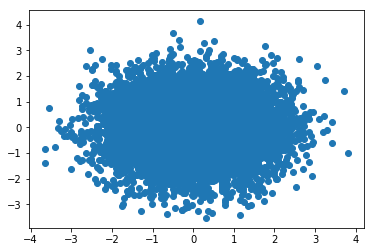

In [7]:
#Prior distribution
def P_z(size,type=None):
    if size[1] is 2:
        #samples at 2D 10-giassuain mix
        p=np.random.randint(low=0, high=10, size=(size[0],1))
        samples_x=np.zeros((size[0],1))
        samples_y=np.zeros((size[0],1))

        r=4
        theta=np.pi*2/10
        for i in range(10):
            samples_x+=(p==i)*np.random.normal(loc=r*(np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
            samples_y+=(p==i)*np.random.normal(loc=r*(-np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
        return np.hstack([samples_x,samples_y]).astype(floatX)
    else:
        return np.random.normal(size=size).astype(floatX)

#Esamples of samples from the mixutre distribution
Z=P_z(size=(10000,myOpts.n_hidden))
print np.shape(Z)
plt.scatter(Z[:,0],Z[:,1])

In [8]:
##Training function
def train(opts):
    train_rec,train_dis,train_enc,anneal,  sample,encode,reconstruct,  enc,dec,dis=prep_train(opts)
    x_train,y_train,x_test,y_test,x_val,y_val=load_data()
    
    batches=int(float(x_train.shape[0])/opts.batchsize)
    
    #Tally of costs
    cost_rec=[] #reconstruction cost of the encoder, decoder net
    cost_dis=[] #aversarial cost on discriminator
    cost_enc=[] #adversarial cost on encoding
    test_cost_rec=[] #reconstruction error on test set
    
    n=0
    print 'epoch   batch   cost_dis   cost_enc   cost_rec   time '
    for e in range(opts.epoch):
        timer = time.time()
        for b in range(batches):
            #Z = np.random.normal(size=(opts.batchsize,opts.n_hidden)).astype(floatX)
            Z=P_z(size=(opts.batchsize,opts.n_hidden))
            X=x_train[b*opts.batchsize:(1+b)*opts.batchsize]
            
            #train the autoencer (enc and dec) (w/ reconstruction loss)
            cost_rec.append(train_rec(X))
            #train the discriminator
            cost_dis.append(train_dis(X,Z))
            #train the encoder (w/ adversarial) 
            cost_enc.append(train_enc(X))
            
            #check for over fitting (try reconstruct training samples
            if n%10==0:
                mse_test,x_rec_test=reconstruct(x_test[:opts.batchsize])
            test_cost_rec.append(bce(x_rec_test,x_test[:opts.batchsize]).eval().mean())
            n+=1
            
        print "%d \t %d  \t %.3f \t %.3f \t %.3f \t %.3f \t %.2f" % (e,b,cost_dis[-1],cost_enc[-1],cost_rec[-1], test_cost_rec[-1], time.time()-timer)
        a=anneal()
        print a
    return sample,encode,reconstruct,cost_enc,cost_rec,cost_dis,test_cost_rec
    

In [9]:
# script ot apply trained encode, reconstruct, sample functions to x_train, x_test and x_val in batches
def apply(model, data, opts):
    output=[]
    batches=int(float(data.shape[0])/opts.batchsize)
    for b in range(batches):
        temp=model(data[b*myOpts.batchsize:(b+1)*myOpts.batchsize])
        output.append(temp)
    return np.concatenate(output)

In [ ]:
##Training 
sample,encode,reconstruct,cost_enc,cost_rec,cost_dis,test_cost_rec=train(myOpts)

In [ ]:
#Save all models:
import pickle
dir='DAAE_v2_sprite_params'
pickle.dump(sample,open(dir+'/sample.pkl','w'))
pickle.dump(encode,open(dir+'/encode.pkl','w'))
pickle.dump(reconstruct,open(dir+'/reconstruct.pkl','w'))
pickle.dump(myOpts,open(dir+'/myOpts.pkl','w'))
np.save(dir+'/cost_enc.npy',cost_enc)
np.save(dir+'/cost_rec.npy',cost_rec)
np.save(dir+'/cost_dis.npy',cost_dis)

In [10]:
#load all models:
import pickle
dir='DAAE_v2_sprite_params'
dir='/home/ac2211/Documents/PhD_Yr1/Projects/Project17_DAAE/Expeirments/DAAE_sprites_v2/v2_noise_M5/DAAE_v2_sprite_params/' #where my saved models are
sample=pickle.load(open(dir+'/sample.pkl','r'))
encode=pickle.load(open(dir+'/encode.pkl','r'))
reconstruct=pickle.load(open(dir+'/reconstruct.pkl','r'))
myOpts=pickle.load(open(dir+'/myOpts.pkl','r'))
cost_enc=np.load(dir+'/cost_enc.npy')
cost_rec=np.load(dir+'/cost_rec.npy')
cost_dis=np.load(dir+'/cost_dis.npy')

print 'sigma:',myOpts.sigma,', n_hidden',myOpts.n_hidden, ', M', myOpts.M

sigma: 0.25 , n_hidden 200 , M 5


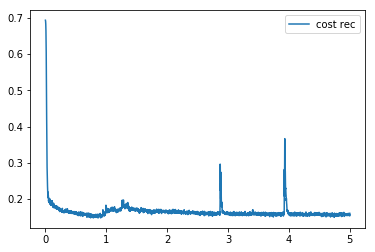

In [11]:
##Training Plots
#Cost plots
x_train,y_train,x_test,y_test,x_val,y_val=load_data()
step=1./int(float(x_train.shape[0])/myOpts.batchsize)
y=np.arange(0,myOpts.epoch,step)
#plt.plot(y,cost_dis,label='cost dis')
#plt.plot(y,cost_enc,label='cost enc')
plt.plot(y,cost_rec,label='cost rec')
#plt.plot(y,test_cost_rec, label='tect cost rec')
plt.legend()

(128, 3, 60, 60) (128, 3, 60, 60)
mean squared error loss: 0.0183585 +/- 0.00552925559286
(3, 180, 600)


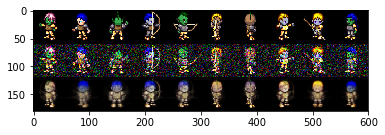

In [12]:
#Apply reconstruction to all the test images
rec=apply(reconstruct, x_test,myOpts)
x_rec=rec[1]; x_rec_loss=rec[0]
print np.shape(x_rec), np.shape(x_rec_loss)
print "mean squared error loss:", np.mean(x_rec_loss), '+/-', np.std(x_rec_loss)/np.sqrt(x_rec_loss.shape[0])
eg_test=[x_test[egs].transpose(0,2,1) for egs in range(0,120,12)]
eg_rec=[x_rec[egs].transpose(0,2,1) for egs in range(0,120,12)]
x_noise=(eg_test+myOpts.sigma*np.random.normal(size=(10,3,60,60))).clip(0,1)
im=np.dstack(np.dstack(([eg_test,x_noise,eg_rec])))
print np.shape(im)
plt.imshow(im.transpose(1,2,0))
plt.figure()

(17792, 200)


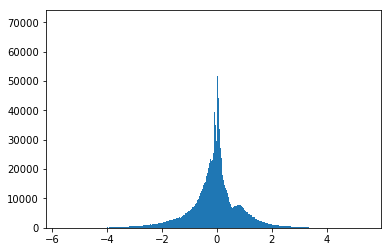

In [13]:
##Encodings
#Encode
x_enc=apply(encode,x_test,myOpts)
print np.shape(x_enc)
#Look at histrograms of encodings (For 10D Gaussian)
if myOpts.n_hidden>2:
        plt.hist(x_enc.flatten(),1000) #each axis will b diff colour
if myOpts.n_hidden==2:
    plt.scatter(x_enc[:,0],x_enc[:,1])

(3, 300, 300)


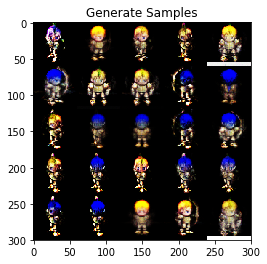

In [14]:
##Samples:
#Draw from the prior and sample (random)
row=col=5
noSamples=row*col
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_samples=sample(Z).reshape(noSamples,3,60,60)
#display as montage
montage=np.zeros((3,row*60,col*60))
n=0
for r in range(row):
    for c in range(col):
        montage[:,r*60:(r+1)*60,c*60:(c+1)*60]=x_samples[n]; n+=1;
print np.shape(montage)
plt.imshow(montage.transpose(2,1,0))
plt.title('Generate Samples')

In [15]:
## THEANO log likelihood (should be faster)
noSamples=10**3
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_sample=sample(Z)
print np.shape(x_sample)
x_sample_grey=rgb2gray(x_sample.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)
x_val_grey=rgb2gray(x_val.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)
x_test_grey=rgb2gray(x_test.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)
print np.shape(x_sample_grey), np.shape(x_val_grey), np.shape(x_test_grey)

#cross val to find a sigma
batch_size=32
sigma_range = np.logspace(-1, 0, num=10)
print sigma_range
sigma = cross_validate_sigma(x_sample_grey, x_val_grey, sigma_range, batch_size)
print "sigma*=",sigma
# fit and evaulate
parzen = theano_parzen(x_sample_grey, sigma)
ll = get_nll(x_test_grey, parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_test_grey.shape[0])

print "Log-Likelihood of test set = {}, se: {}".format(ll.mean(), se)

# valid
ll = get_nll(x_val_grey, parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_val_grey.shape[0])
print "Log-Likelihood of valid set = {}, se: {}".format(ll.mean(), se)

(1000, 3, 60, 60)
(1000, 3600) (12816, 3600) (17800, 3600)
[ 0.1         0.12915497  0.16681005  0.21544347  0.27825594  0.35938137
  0.46415888  0.59948425  0.77426368  1.        ]
0.1
0 0.42120885849 1802.91088963
100 0.403790891761 1704.12014439
200 0.402984485104 1715.16248104
300 0.402743254785 1711.03369701
400 0.403697957422 1713.6541754
0.129154966501
0 0.40457201004 2152.04782377
100 0.405538615614 2092.8196758
200 0.404443315013 2099.43956258
300 0.405279289448 2096.96466933
400 0.404684220169 2098.53575745
0.16681005372
0 0.410759210587 1992.46684636
100 0.410193905972 1956.95531991
200 0.406613361776 1960.92406009
300 0.405885892057 1959.44041238
400 0.405336478702 1960.38247413
0.215443469003
0 0.406857967377 1527.92193706
100 0.402727117633 1506.62645552
200 0.403241260728 1509.00603572
300 0.405041714443 1508.11617581
400 0.405374955061 1508.68128139
0.278255940221
0 0.406539916992 880.563591355
100 0.407314583807 867.786398358
200 0.405527078097 869.213644365
300 0.4042

In [ ]:
exit()

In [ ]:
print theano.config.floatX